## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# define the calibrate camera method
def callibrate_camera():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    print("Image and Object Points Acquired")
    return (objpoints,imgpoints)

def displayTwoImages(img1,img1Title,img2,img2Title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(img1Title, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(img2Title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
def displayImage(img1,img1Title):
    f, (ax1) = plt.subplots(1, 1, figsize=(20, 6))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(img1Title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    
def displayImageGray(img1,img1Title):
    f, (ax1) = plt.subplots(1, 1, figsize=(20, 6))
    f.tight_layout()
    ax1.imshow(img1, cmap = 'gray')
    ax1.set_title(img1Title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)        

## 2. Use the image and object points to perform camera calibration, image distortion correction and return the undistorted image

Image and Object Points Acquired


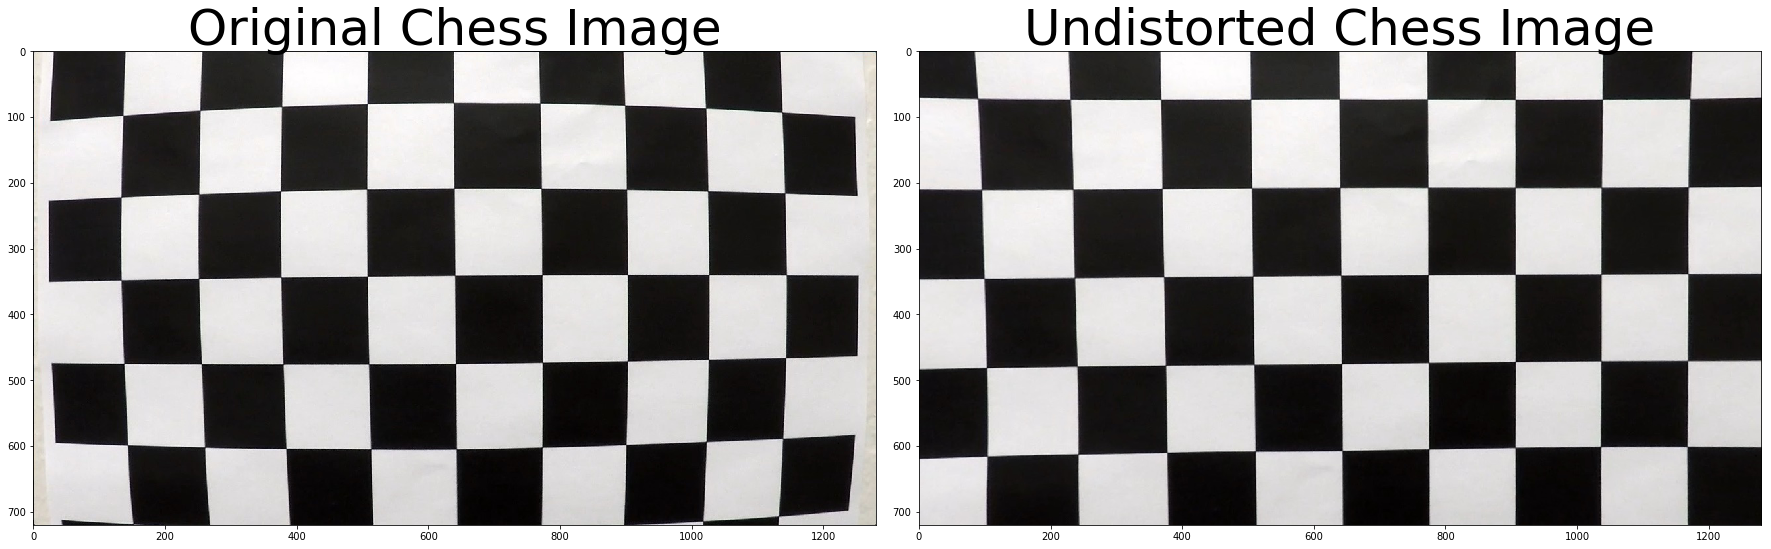

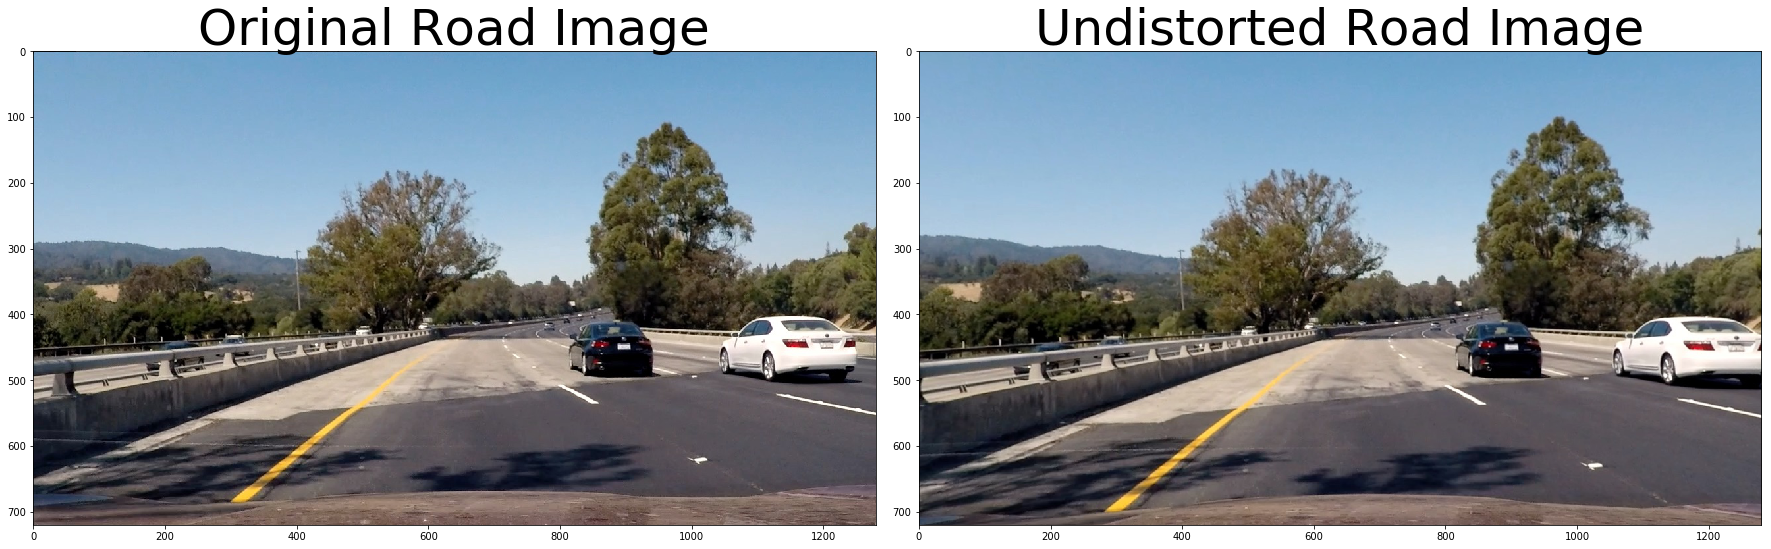

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Testing out the calibration and undistort function
img1 = mpimg.imread('./test_images/test4.jpg')
img2 = mpimg.imread('./camera_cal/calibration1.jpg')
objpoints,imgpoints = callibrate_camera()
undistorted1 = cal_undistort(img1, objpoints, imgpoints)
undistorted2 = cal_undistort(img2, objpoints, imgpoints)
displayTwoImages(img2,'Original Chess Image',undistorted2,'Undistorted Chess Image')
displayTwoImages(img1,'Original Road Image',undistorted1,'Undistorted Road Image')

## 3. Color/Gradient Threshold

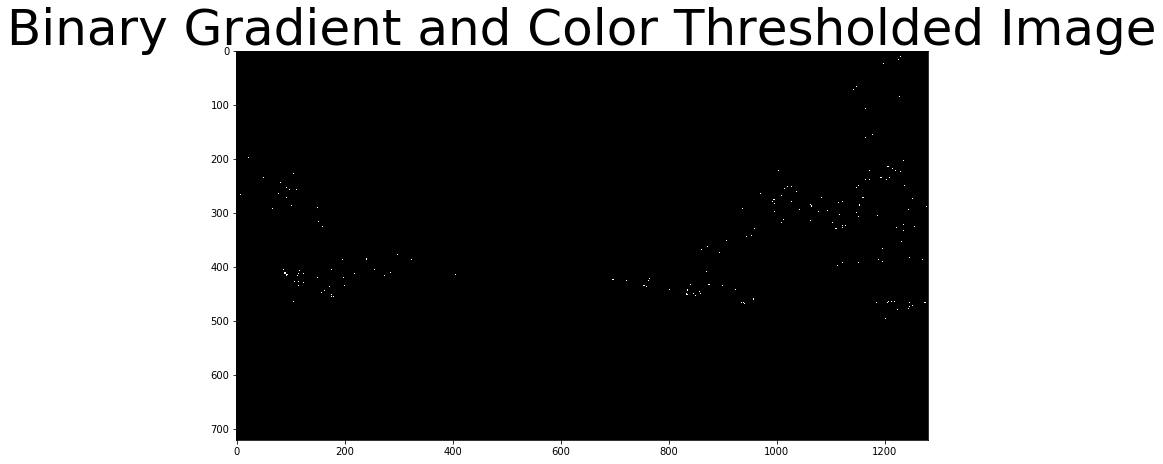

In [3]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    grad_binary = binary_output
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(abs_sobelx)+np.square(abs_sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    mag_binary = binary_output
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
        # Apply the following steps to img
    # 1) Convert to grayscale
    
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobelArcTan = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobelArcTan)
    binary_output[(sobelArcTan >= thresh[0]) & (sobelArcTan <= thresh[1])] = 1
    dir_binary = binary_output
    return dir_binary

def color_threshold(img, thresh=(0, 255)):
    s_channel = img[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

    

image = mpimg.imread('./test_images/straight_lines2.jpg')
# Store grayscale version of image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Store HLS version of image
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)


# Apply all thresholding functions
def update(ksize, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_dir, max_dir,
           min_colorT, max_colorT):
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(min_gradx, max_gradx))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(min_grady, max_grady))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(min_mag, max_mag))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(min_dir, max_dir))
    s_binary = color_threshold(hls, thresh=(min_colorT,max_colorT))
    #combined = np.zeros_like(dir_binary)
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    displayImageGray(combined,'Binary Gradient and Color Thresholded Image')

# Use interaction sliders to be able to manipulate thresholds easier
interact(update,ksize=(1,31,2), 
         min_gradx=(0,255), max_gradx=(0,255),
         min_grady=(0,255), max_grady=(0,255),
         min_mag=(0,255),  max_mag=(0,255),
         min_dir=(0,np.pi/2), max_dir=(0, np.pi/2),
         min_colorT=(0,255), max_colorT=(0,255))

    
def binaryThresholdedImage(image, ksize, min_gradx, max_gradx, 
                           min_grady, max_grady, min_mag, max_mag, 
                           min_dir, max_dir, min_colorT, max_colorT):
    # Store grayscale version of image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Store HLS version of image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(min_gradx, max_gradx))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(min_grady, max_grady))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(min_mag, max_mag))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(min_dir, max_dir))
    s_binary = color_threshold(hls, thresh=(min_colorT,max_colorT))
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    return combined

## 3. Perspective Transform

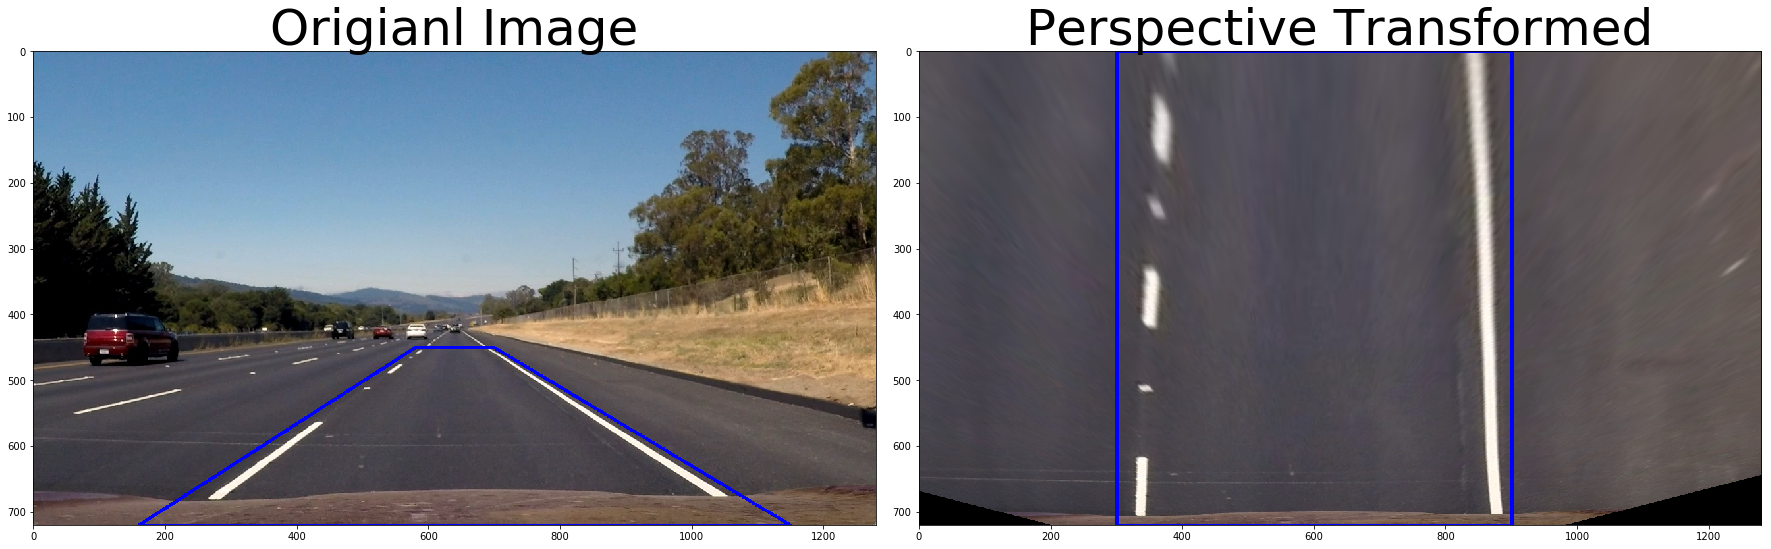

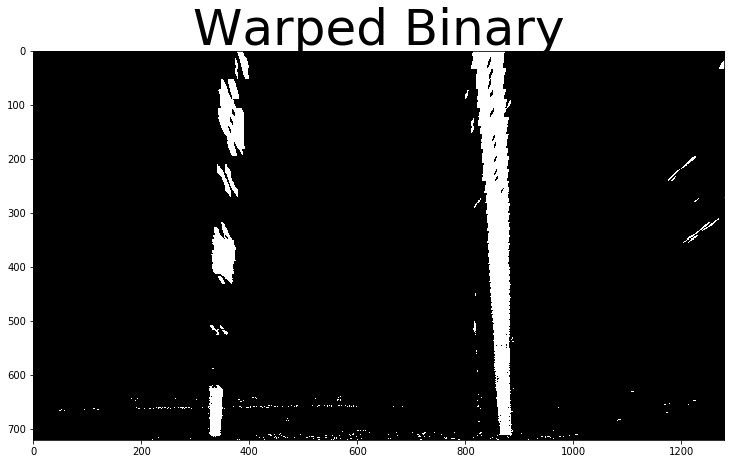

In [4]:
# Define perspective transform
def perspectiveTransform(image):
    #define image shape and size
    imshape = image.shape
    img_size = (image.shape[1],image.shape[0])
    
    #define src points
    v_bottom_left = (160,imshape[0])
    v_bottom_right = (1150,imshape[0])
    v_top_left = (580, 450)
    v_top_right = (700, 450)
    src = np.float32([v_bottom_left, v_top_left, v_top_right, v_bottom_right])
    
    #define dst points
    bottom_left_w = (300, imshape[0])
    bottom_right_w = (900, imshape[0])
    top_left_w = (300, 0)
    top_right_w = (900, 0)
    dst = np.float32([bottom_left_w,top_left_w,top_right_w,bottom_right_w])
    
    # calculate M and Minv
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp perspective
    warpedImage = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return (M,Minv,warpedImage)


# Testing out prespective transform method
image = mpimg.imread('./test_images/straight_lines2.jpg')
undist = cal_undistort(image, objpoints, imgpoints)

#Parameters and Thresholds
ksize = 15
min_gradx = 23
max_gradx = 180
min_grady = 27
max_grady = 187
min_mag = 16
max_mag = 180 
min_dir = 0.7
max_dir = 1.3
min_colorT = 142 
max_colorT = 255

# get binary image
binary = binaryThresholdedImage(undist, ksize, min_gradx, max_gradx, 
                                            min_grady, max_grady, min_mag, max_mag, 
                                            min_dir, max_dir, min_colorT, max_colorT)

# Test perspective transoform on original image
M,Minv,warped = perspectiveTransform(image)

# Apply perspective transform on binary image
M,Minv,binary_warped = perspectiveTransform(binary)


imshape = image.shape

#define src points
v_bottom_left = (160,imshape[0])
v_bottom_right = (1150,imshape[0])
v_top_left = (580, 450)
v_top_right = (700, 450)

#define dst points
bottom_left_w = (300, imshape[0])
bottom_right_w = (900, imshape[0])
top_left_w = (300, 0)
top_right_w = (900, 0)

# Display the images
vertices = np.array([[v_bottom_left, v_top_left, v_top_right, v_bottom_right]], dtype=np.int32)
cv2.polylines(image, vertices, True, (0,0,255), 3)
vertices = np.array([[bottom_left_w, top_left_w, top_right_w, bottom_right_w]], dtype=np.int32)
cv2.polylines(warped, vertices, True, (0,0,255), 3)
displayTwoImages(image,'Origianl Image',warped,'Perspective Transformed')
displayImageGray(binary_warped,'Warped Binary')

In [5]:
def detectLines(binary_warped):
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Choose the number of sliding windows
    nwindows = 9
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
   
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    return (out_img,left_fitx,right_fitx,ploty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds,left_fit,right_fit)

/home/shaarany/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

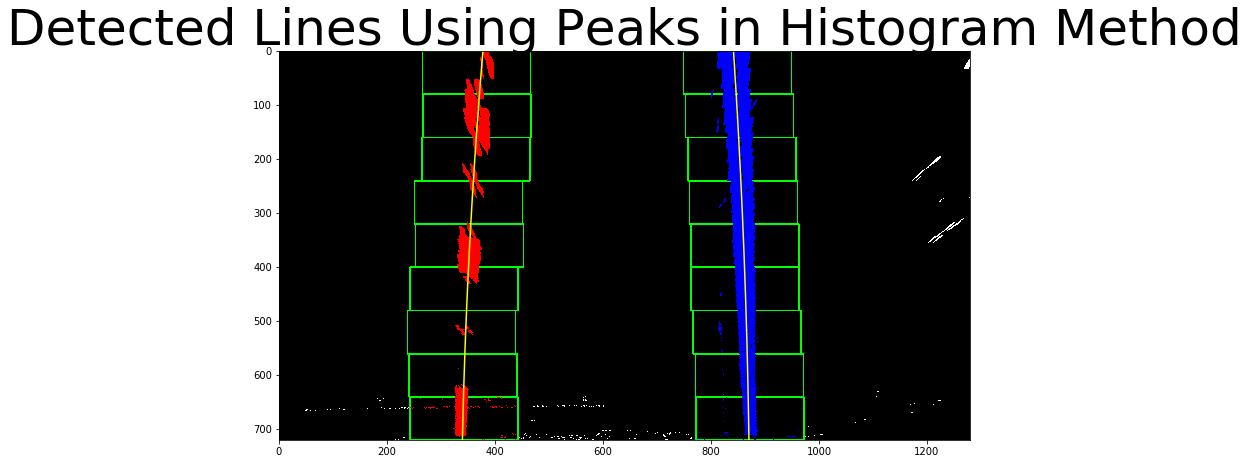

In [6]:
# Detect lines using Peaks in a Histogram method
(out_img,left_fitx,right_fitx,ploty,nonzerox,nonzeroy,left_lane_inds,right_lane_inds,left_fit,right_fit) = detectLines(binary_warped)

#plt.imshow(out_img)
displayImage(out_img,"Detected Lines Using Peaks in Histogram Method")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [7]:
def searchInMargin(binary_warped,left_fit,right_fit):
    # Assume you now have a new warped_straight_lines.jpged binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return(left_fitx,right_fitx)

(720, 0)

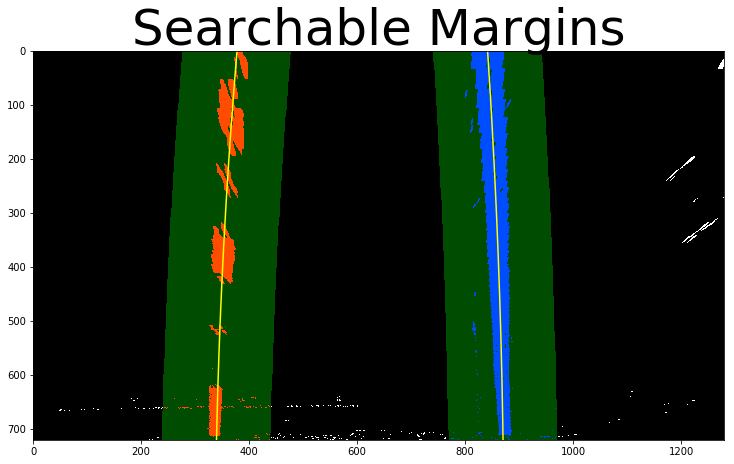

In [8]:
# Plot the margins with in which to search for the lines in the next frame

# Define Margin
margin = 100
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))


# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#plt.imshow(result)
displayImage(result,"Searchable Margins")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [9]:
def CalculateRadCurvMeters(binary_warped, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = binary_warped.shape[0]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m 626.2 m
    return left_curverad, right_curverad

def offsetCalc(img,left_fitx,right_fitx):
    return ((img.shape[1]/2)-((left_fitx[img.shape[1]-1]+right_fitx[img.shape[1]-1])/2))*3.7/700

In [10]:
def drawResult(vid_img,binary_warped,undist_p,ploty,left_fitx,right_fitx,Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (vid_img.shape[1], vid_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_p, 1, newwarp, 0.3, 0)
    return result

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define the Lane Detect Object
class LaneDetect:
    def __init__(self,objpoints,imgpoints):
        #left_fit_array = []
        #right_fit_array = []
        self.left_fitx = []
        self.right_fitx = []
        self.left_fit = []
        self.right_fit = []
        self.num_bad_frames = 0
        self.max_num_bad_frames = 50
        self.ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
        self.detectLines = True
        self.leftRadCurv = 0
        self.rightRadCurv = 0
        
        # Parameters and Thresholds
        self.ksize = 15
        self.min_gradx = 23
        self.max_gradx = 180
        self.min_grady = 27
        self.max_grady = 187
        self.min_mag = 16
        self.max_mag = 180 
        self.min_dir = 0.7
        self.max_dir = 1.3
        self.min_colorT = 142 
        self.max_colorT = 255
        
        # define object and image points
        self.objpoints = objpoints
        self.imgpoints = imgpoints
        
        # define M and Minv
        self.M = []
        self.Minv = []
        
        # define num of frames to average over
        self.maxNumFrames = 10
        
        # define number of stored frames
        self.numStoredFrames = 0
    
    def detectLinesFunc(self, binary_warped):
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Choose the number of sliding windows
        nwindows = 9
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        return (left_fit,right_fit)
        
    def searchInMarginFunc(self, binary_warped):
        # Assume you now have a new warped_straight_lines.jpged binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (np.mean(self.left_fit,axis=0)[0]*(nonzeroy**2) + np.mean(self.left_fit,axis=0)[1]*nonzeroy + np.mean(self.left_fit,axis=0)[2] - margin)) & (nonzerox < (np.mean(self.left_fit,axis=0)[0]*(nonzeroy**2) + np.mean(self.left_fit,axis=0)[1]*nonzeroy + np.mean(self.left_fit,axis=0)[2] + margin))) 
        right_lane_inds = ((nonzerox > (np.mean(self.right_fit,axis=0)[0]*(nonzeroy**2) + np.mean(self.right_fit,axis=0)[1]*nonzeroy + np.mean(self.right_fit,axis=0)[2] - margin)) & (nonzerox < (np.mean(self.right_fit,axis=0)[0]*(nonzeroy**2) + np.mean(self.right_fit,axis=0)[1]*nonzeroy + np.mean(self.right_fit,axis=0)[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        return (left_fit,right_fit)
        
        
    def drawResultFunc(self, vid_img,binary_warped,undist_p):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (vid_img.shape[1], vid_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_p, 1, newwarp, 0.3, 0)
        return result        
    
    def CalculateRadCurvMeters(self, binary_warped,left_fitx,right_fitx):

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        y_eval = binary_warped.shape[0]

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(self.ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        # Now our radius of curvature is in meters
        # Example values: 632.1 m 626.2 m
        return left_curverad, right_curverad

    def sanityCheck(self, binary_warped_p, left_fitx, right_fitx):
        # check radius of curvature
        (left_curverad, right_curverad) = self.CalculateRadCurvMeters(binary_warped_p,left_fitx,right_fitx)
        #if( abs(left_curverad - right_curverad) <= 400):
        if( abs(left_curverad - right_curverad) <= 350 and 450 < np.mean(right_fitx-left_fitx) and np.mean(right_fitx-left_fitx)  < 550):
            (self.leftRadCurv,self.rightRadCurv) = (left_curverad, right_curverad)
            return True
        else:
            return False
        
    def process_frame(self, frame):
        # process frame

        # undistord the frame
        undist_p = cal_undistort(frame, self.objpoints, self.imgpoints)

        # Geneterate the binary thresholded image
        binary_p = binaryThresholdedImage(undist_p, self.ksize, self.min_gradx, self.max_gradx, 
                                            self.min_grady, self.max_grady, self.min_mag, self.max_mag, 
                                            self.min_dir, self.max_dir, self.min_colorT, self.max_colorT)

        # calculate M and Minv, and warp binary image
        self.M, self.Minv, binary_warped_p = perspectiveTransform(binary_p)

        # Detect Lines for first time
        if(self.detectLines):
            #detect lines
            (left_fit,right_fit) = self.detectLinesFunc(binary_warped_p)
            self.left_fit.append(left_fit)
            self.right_fit.append(right_fit)
            self.left_fitx = np.mean(self.left_fit,axis=0)[0]*self.ploty**2 + np.mean(self.left_fit,axis=0)[1]*self.ploty + np.mean(self.left_fit, axis=0)[2]
            self.right_fitx = np.mean(self.right_fit,axis=0)[0]*self.ploty**2 + np.mean(self.right_fit,axis=0)[1]*self.ploty + np.mean(self.right_fit,axis=0)[2]
            self.numStoredFrames += 1
            self.detectLines = False
            (self.leftRadCurv,self.rightRadCurv) = self.CalculateRadCurvMeters(binary_warped_p,self.left_fitx,self.right_fitx)
        else:
            # Search within previous window
            (left_fit,right_fit) = self.searchInMarginFunc(binary_warped_p)
            
            # calculate left and right x coordinate
            left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
            right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
            
            # if passed sanityCheck, add to array of lines
            if(self.sanityCheck(binary_warped_p, left_fitx, right_fitx)):
                # reset number of bad frames
                self.num_bad_frames = 0
                
                # if still haven't reached maxNumFrames for smoothing
                if(self.numStoredFrames < self.maxNumFrames):
                    self.left_fit.append(left_fit)
                    self.right_fit.append(right_fit)
                    self.numStoredFrames += 1
                else:
                    self.left_fit = self.left_fit[1:]
                    self.right_fit = self.right_fit[1:]
                    self.left_fit.append(left_fit)
                    self.right_fit.append(right_fit)
                
                # calculate left and right x coordinate
                self.left_fitx = np.mean(self.left_fit,axis=0)[0]*self.ploty**2 + np.mean(self.left_fit,axis=0)[1]*self.ploty + np.mean(self.left_fit, axis=0)[2]
                self.right_fitx = np.mean(self.right_fit,axis=0)[0]*self.ploty**2 + np.mean(self.right_fit,axis=0)[1]*self.ploty + np.mean(self.right_fit,axis=0)[2]

            else:
                if(self.num_bad_frames == self.max_num_bad_frames):
                    (left_fit,right_fit) = self.detectLinesFunc(binary_warped_p)
                    # if still haven't reached maxNumFrames for smoothing
                    if(self.numStoredFrames < self.maxNumFrames):
                        self.left_fit.append(left_fit)
                        self.right_fit.append(right_fit)
                        self.numStoredFrames += 1
                    else:
                        self.left_fit = self.left_fit[1:]
                        self.right_fit = self.right_fit[1:]
                        self.left_fit.append(left_fit)
                        self.right_fit.append(right_fit)
                
                    # calculate left and right x coordinate
                    self.left_fitx = np.mean(self.left_fit,axis=0)[0]*self.ploty**2 + np.mean(self.left_fit,axis=0)[1]*self.ploty + np.mean(self.left_fit, axis=0)[2]
                    self.right_fitx = np.mean(self.right_fit,axis=0)[0]*self.ploty**2 + np.mean(self.right_fit,axis=0)[1]*self.ploty + np.mean(self.right_fit,axis=0)[2]

                    # reset number of bad frames found to zero
                    self.num_bad_frames = 0
                    (self.leftRadCurv,self.rightRadCurv) = self.CalculateRadCurvMeters(binary_warped_p,self.left_fitx,self.right_fitx)
                else:
                    self.num_bad_frames += 1

        
        #Calculate Radius of Curvature in meters
        RadCurv = ((self.leftRadCurv+self.rightRadCurv))/2
        # Calculate Offset in meters
        offset = ((binary_warped_p.shape[1]/2)-((self.left_fitx[719]+self.right_fitx[719])/2))*3.7/700
        # return frame
        
        # Add Radius and Offset to image
        font = cv2.FONT_HERSHEY_COMPLEX
        resultImage = self.drawResultFunc(frame,binary_warped_p,undist_p)
        cv2.putText(resultImage, 'Estimated lane curvature: {}'.format(round(RadCurv, 3)), (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(resultImage, 'Estimated Offset from Lane Center: {}'.format(round(offset,3)), (30, 90), font, 1, (255,0,0), 2)
        return resultImage


vid_output = './harder_challenge_output_project_video.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
my_object = LaneDetect(objpoints, imgpoints)
vid_clip = clip1.fl_image(my_object.process_frame)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video ./harder_challenge_output_project_video.mp4
[MoviePy] Writing video ./harder_challenge_output_project_video.mp4


100%|█████████▉| 1199/1200 [29:04<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_output_project_video.mp4 

CPU times: user 30min 30s, sys: 2.54 s, total: 30min 33s
Wall time: 29min 6s
